## Import libraries

In [1]:
import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## 0. Load data

In [244]:
data_path_in = "./data/titanic_data/"

In [245]:
df_train = pd.read_csv(data_path_in + "train.csv")
print(df_train.shape)

(891, 12)


## 1. Preliminary analysis

In [246]:
df_train.head(7)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


"PassengerId" is just a numeric (and unique) identifier per passenger, which provides no relevant information. If there were other tables with additional data which could be linked to this one via such id, we'd use it for joining them all, but this is not the case.
Conclusion: We drop it before going on.

In [247]:
df_train.drop("PassengerId", axis=1, inplace=True)

We also mark the target variable

In [248]:
target = ["Survived"]

In [249]:
def df_custom_info(df, disc_threshold = 5):
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    
    info_df = pd.DataFrame({"Column Name": df.columns,
                            "Missing Data Percentage": percent_missing})
    
    threshold_num = np.ceil(df.shape[0] * (disc_threshold / 100))
    unique_val_counts = []
    for col in df.columns:
        unique_val_counts.append(len(list(df[col].value_counts().index)))    
    
    info_df['Num. Unique Values'] = unique_val_counts
    
    data_types = []
    for col in df.columns:
        data_types.append(df[col].dtype.name)   
    
    info_df['Data Type'] = data_types
    
    info_df['Feature Type'] = ''
    info_df.loc[info_df['Num. Unique Values'] > threshold_num,'Feature Type'] = 'Continuous'
    info_df.loc[info_df['Num. Unique Values'] < threshold_num,'Feature Type'] = 'Discrete'
    info_df.loc[info_df['Num. Unique Values'] == 2,'Feature Type'] = 'Binary'
    
    info_df.sort_values("Missing Data Percentage", ascending=False, inplace=True)
    
    return info_df 

In [250]:
db_aux_MV = df_custom_info(df_train, disc_threshold = 5)
db_aux_MV

,Column Name,Missing Data Percentage,Num. Unique Values,Data Type,Feature Type
Cabin,Cabin,77.104377,147,object,Continuous
Age,Age,19.865320,88,float64,Continuous
Embarked,Embarked,0.224467,3,object,Discrete
Survived,Survived,0.000000,2,int64,Binary
Pclass,Pclass,0.000000,3,int64,Discrete
Name,Name,0.000000,891,object,Continuous
Sex,Sex,0.000000,2,object,Binary
SibSp,SibSp,0.000000,7,int64,Discrete
Parch,Parch,0.000000,7,int64,Discrete
Ticket,Ticket,0.000000,681,object,Continuous


### 1.1 We analyse fts with data type = "object" and cast them to appropriate types

In [251]:
ft_obj = db_aux_MV[db_aux_MV["Data Type"] == "object"].loc[:,'Column Name'].tolist()
ft_obj

['Cabin', 'Embarked', 'Name', 'Sex', 'Ticket']

In [252]:
df_train.loc[:,ft_obj].head(10)

,Cabin,Embarked,Name,Sex,Ticket
0,NaN,S,"Braund, Mr. Owen Harris",male,A/5 21171
1,C85,C,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599
2,NaN,S,"Heikkinen, Miss. Laina",female,STON/O2. 3101282
3,C123,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803
4,NaN,S,"Allen, Mr. William Henry",male,373450
5,NaN,Q,"Moran, Mr. James",male,330877
6,E46,S,"McCarthy, Mr. Timothy J",male,17463
7,NaN,S,"Palsson, Master. Gosta Leonard",male,349909
8,NaN,S,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,347742
9,NaN,C,"Nasser, Mrs. Nicholas (Adele Achem)",female,237736


* Name is a text feature that requires further analysis and engineering: extract name, surname, title...

* Sex is categorical and binary, and it'll be treated as such

* Ticket is composed of alphanumeric codes and there are plenty of distinct values. Further analysis is required to see if the alphanumeric codes present some pattern (e. g.: "do the prefixes mean sth?")

* Cabin is categorical and has many distinct values and a large proportion of missing data. An analysis of the alphanumeric code and the influence of the data shortage are required.

* Embarked is categorical (3 categories, not ordinal) and it'll be casted accordingly

In [253]:
df_train["Sex"] = df_train["Sex"].astype("category")
df_train["Embarked"] = df_train["Embarked"].astype("category")

In [254]:
df_custom_info(df_train,disc_threshold = 5)

,Column Name,Missing Data Percentage,Num. Unique Values,Data Type,Feature Type
Cabin,Cabin,77.104377,147,object,Continuous
Age,Age,19.865320,88,float64,Continuous
Embarked,Embarked,0.224467,3,category,Discrete
Survived,Survived,0.000000,2,int64,Binary
Pclass,Pclass,0.000000,3,int64,Discrete
Name,Name,0.000000,891,object,Continuous
Sex,Sex,0.000000,2,category,Binary
SibSp,SibSp,0.000000,7,int64,Discrete
Parch,Parch,0.000000,7,int64,Discrete
Ticket,Ticket,0.000000,681,object,Continuous


### 1.2 Some EDA (numeric and graphical)

Target variable

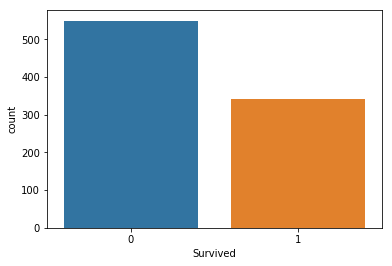

In [255]:
_ = sns.countplot(df_train["Survived"])

Discrete features

/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


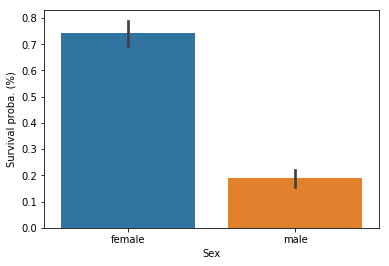

In [95]:
g = sns.barplot(y ='Survived', x='Sex',data=df_train)
_ = g.set(xlabel='Sex', ylabel='Survival proba. (%)')

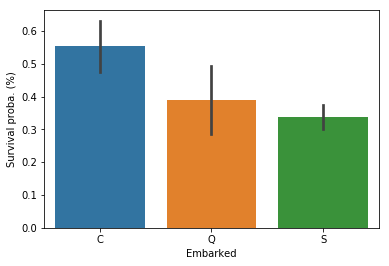

In [96]:
g = sns.barplot(y ='Survived', x='Embarked',data=df_train)
_ = g.set(xlabel='Embarked', ylabel='Survival proba. (%)')

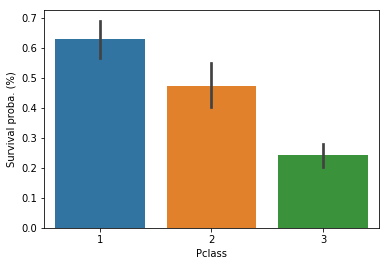

In [97]:
g = sns.barplot(y ='Survived', x='Pclass',data=df_train)
_ = g.set(xlabel='Pclass', ylabel='Survival proba. (%)')

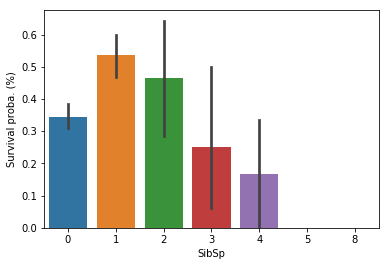

In [98]:
g = sns.barplot(y ='Survived', x='SibSp',data=df_train)
_ = g.set(xlabel='SibSp', ylabel='Survival proba. (%)')

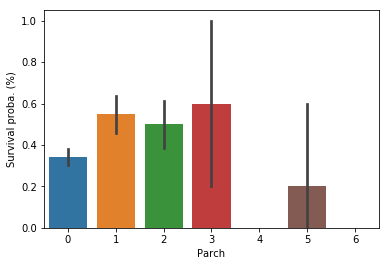

In [99]:
g = sns.barplot(y ='Survived', x='Parch',data=df_train)
_ = g.set(xlabel='Parch', ylabel='Survival proba. (%)')

Continuous features

In [90]:
cont_ft = db_aux_MV[(db_aux_MV["Feature Type"] == "Continuous") & (db_aux_MV["Data Type"] != "object")].loc[:,'Column Name'].tolist()
cont_ft

['Age', 'Fare']

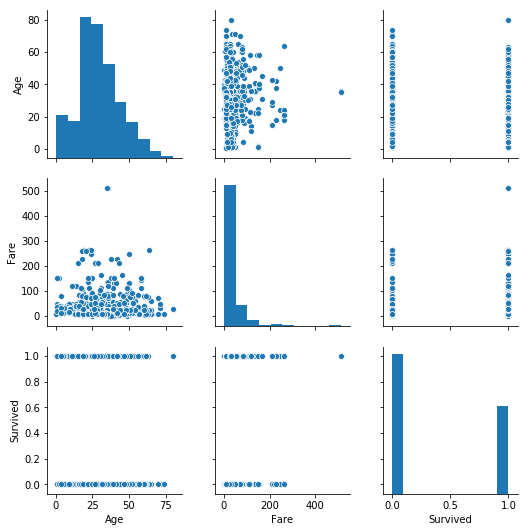

In [91]:
_ = sns.pairplot(df_train.loc[:,cont_ft + target])

In [92]:
def plot_corr_heatmap(corr_mat,figsize=(16,16)):
    ''' Takes a correlation matrix (from Pandas) and returns
    a heatmap based on its values. '''
    # Mask for concealing upper triangle (redundant info)
    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=figsize)
    _ = sns.heatmap(corr_mat, mask=mask, cmap='bwr',annot = True, fmt='2.2f', center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6})

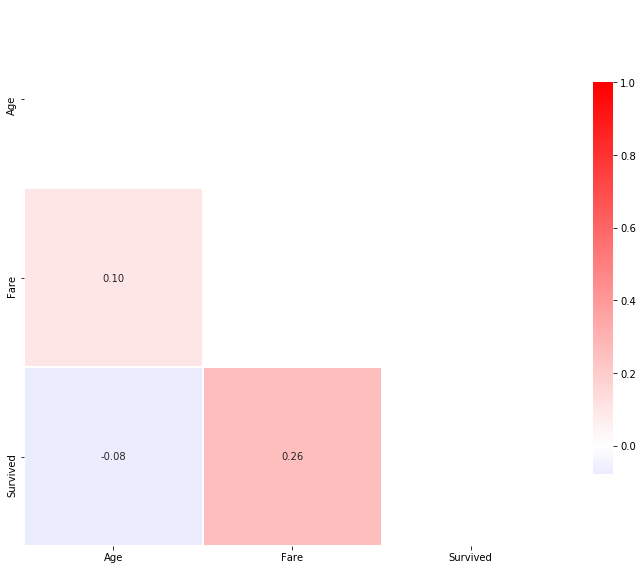

In [94]:
plot_corr_heatmap(df_train.loc[:,cont_ft + target].corr(),figsize=(12,12))

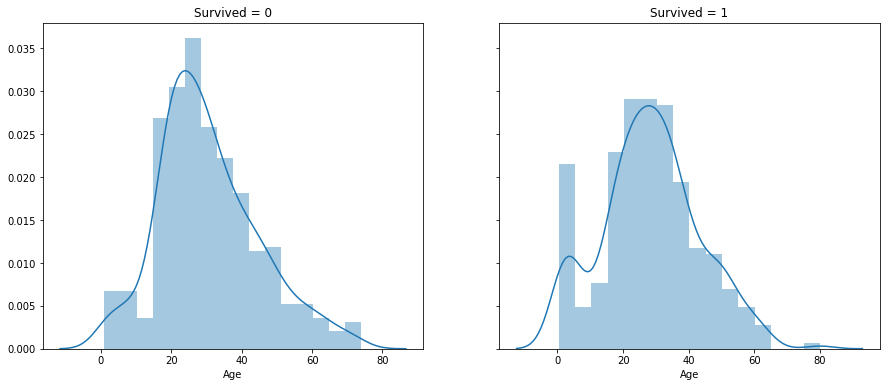

In [117]:
fig, axs = plt.subplots(1,2,figsize=(15,6), sharey=True)
_ = sns.distplot(df_train[df_train["Survived"]==0].loc[:,"Age"].dropna(), ax=axs[0])
_ = axs[0].set_title("Survived = 0")
_ = sns.distplot(df_train[df_train["Survived"]==1].loc[:,"Age"].dropna(), ax=axs[1])
_ = axs[1].set_title("Survived = 1")

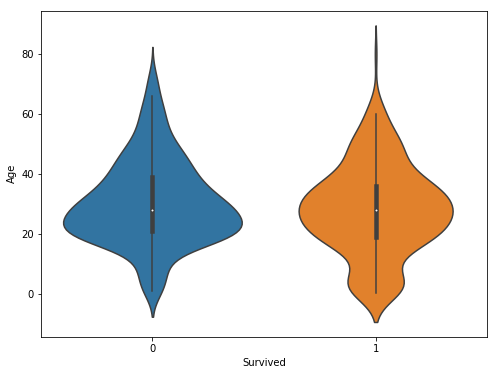

In [125]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
_ = sns.violinplot(x="Survived", y = "Age",data = df_train,ax=axs)

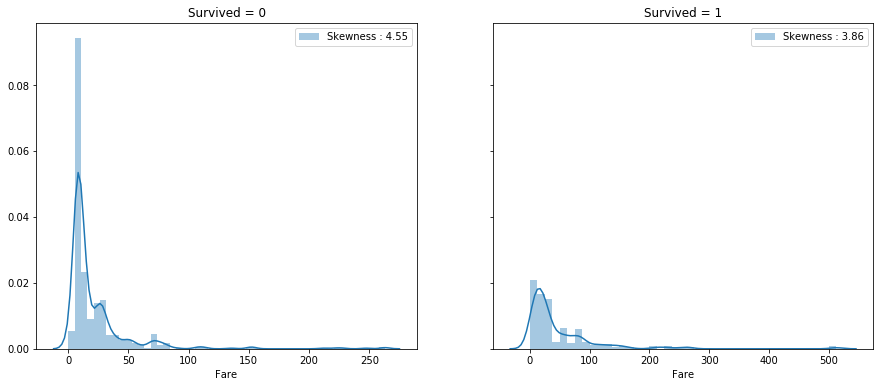

In [116]:
fig, axs = plt.subplots(1,2,figsize=(15,6), sharey=True)
_ = sns.distplot(df_train[df_train["Survived"]==0].loc[:,"Fare"], ax=axs[0],
                 label="Skewness : %.2f"%(df_train[df_train["Survived"]==0].loc[:,"Fare"].skew()))
_ = axs[0].set_title("Survived = 0")
_ = axs[0].legend(loc="best")
_ = sns.distplot(df_train[df_train["Survived"]==1].loc[:,"Fare"], ax=axs[1],
                 label="Skewness : %.2f"%(df_train[df_train["Survived"]==1].loc[:,"Fare"].skew()))
_ = axs[1].set_title("Survived = 1")
_ = axs[1].legend(loc="best")

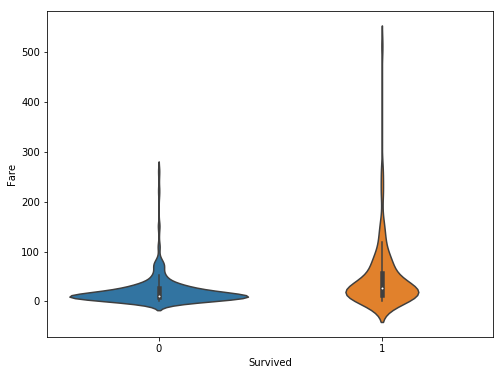

In [126]:
fig, axs = plt.subplots(1,1,figsize=(8,6))
_ = sns.violinplot(x="Survived", y = "Fare",data = df_train,ax=axs)

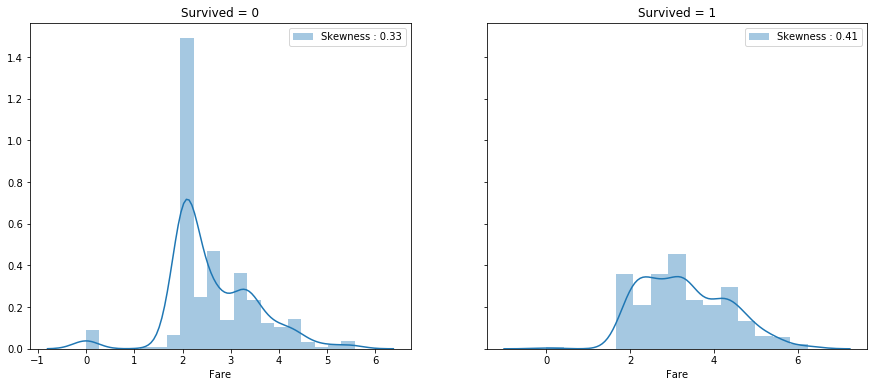

In [118]:
fig, axs = plt.subplots(1,2,figsize=(15,6), sharey=True)
df_aux_log = pd.DataFrame()
df_aux_log["Fare"] = df_train["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
df_aux_log["Survived"] = df_train["Survived"]

_ = sns.distplot(df_aux_log[df_aux_log["Survived"]==0].loc[:,"Fare"], ax=axs[0],
                 label="Skewness : %.2f"%(df_aux_log[df_aux_log["Survived"]==0].loc[:,"Fare"].skew()))
_ = axs[0].set_title("Survived = 0")
_ = axs[0].legend(loc="best")
_ = sns.distplot(df_aux_log[df_aux_log["Survived"]==1].loc[:,"Fare"], ax=axs[1],
                 label="Skewness : %.2f"%(df_aux_log[df_aux_log["Survived"]==1].loc[:,"Fare"].skew()))
_ = axs[1].set_title("Survived = 1")
_ = axs[1].legend(loc="best")

Some combined analysis

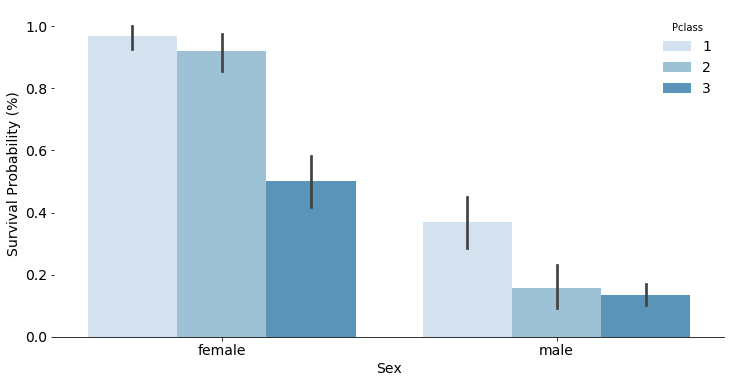

In [122]:
# Figure for ppt
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(y ='Survived', x='Sex',hue='Pclass',
                data=df_train,palette=sns.color_palette("Blues", 4),ax=ax)
ax.set_xlabel('Sex', fontsize=14)
ax.set_ylabel('Survival Probability (%)', fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.legend(title="Pclass",frameon=False,fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

## 2. Feature preparation

### 2.1 Train-Test Split

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
X = df_train.drop(target,axis=1)
y = df_train.loc[:,target]

In [159]:
print(X.shape)
print(X.columns)
print(y.shape)

(891, 10)
Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')
(891, 1)


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [161]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 502 to 80
Data columns (total 10 columns):
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null category
Age         566 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Ticket      712 non-null object
Fare        712 non-null float64
Cabin       160 non-null object
Embarked    710 non-null category
dtypes: category(2), float64(2), int64(3), object(3)
memory usage: 51.6+ KB


In [162]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
502,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
464,3,"Maisner, Mr. Simon",male,NaN,0,0,A/S 2816,8.0500,NaN,S
198,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
765,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,13502,77.9583,D11,S
421,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q


In [163]:
y_train.head()

,Survived
502,0
464,0
198,1
765,1
421,0


### 2.2 Feature Imputation

We'll impute continuous features with their median value (less sensitive to outliers than the mean) and the categorical features with the mode

In [164]:
# We'll isolate those features which are gonna be manually engineered such as text ones, since their imputation will be performed separately
special_ft = ["Name","Cabin","Ticket"]

In [165]:
cont_ft = db_aux_MV[db_aux_MV["Feature Type"] == "Continuous"].loc[:,'Column Name'].tolist()
cont_ft = list(set(cont_ft) - set(special_ft) - set(target))
cont_ft

['Fare', 'Age']

In [166]:
disc_ft = db_aux_MV[(db_aux_MV["Feature Type"] == "Discrete") | (db_aux_MV["Feature Type"] == "Binary")].loc[:,'Column Name'].tolist()
disc_ft = list(set(disc_ft)  - set(special_ft) - set(target))
disc_ft

['Sex', 'Parch', 'SibSp', 'Pclass', 'Embarked']

In [167]:
set(df_train.columns) == set(cont_ft + disc_ft + special_ft + target)

True

In [168]:
X_train_imp = X_train.copy()
X_test_imp = X_test.copy()

In [169]:
X_train_imp.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
502,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
464,3,"Maisner, Mr. Simon",male,NaN,0,0,A/S 2816,8.0500,NaN,S
198,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
765,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,13502,77.9583,D11,S
421,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q


In [170]:
median_imputation = dict()
for ft in cont_ft:
    median_imputation[ft] = X_train_imp[ft].median()
    X_train_imp[ft].fillna(median_imputation[ft], inplace=True)
    X_test_imp[ft].fillna(median_imputation[ft], inplace=True)
    
print(median_imputation)

{'Fare': 14.4583, 'Age': 28.0}


In [171]:
mostfreq_imputation = dict()
for ft in disc_ft:
    mostfreq_imputation[ft] = X_train_imp[ft].mode()[0]
    X_train_imp[ft].fillna(mostfreq_imputation[ft], inplace=True)
    X_test_imp[ft].fillna(mostfreq_imputation[ft], inplace=True)
    
print(mostfreq_imputation)

{'Sex': 'male', 'Parch': 0, 'SibSp': 0, 'Pclass': 3, 'Embarked': 'S'}


In [172]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 502 to 80
Data columns (total 10 columns):
Pclass      712 non-null int64
Name        712 non-null object
Sex         712 non-null category
Age         712 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Ticket      712 non-null object
Fare        712 non-null float64
Cabin       160 non-null object
Embarked    712 non-null category
dtypes: category(2), float64(2), int64(3), object(3)
memory usage: 51.6+ KB


In [173]:
X_train_imp.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
502,3,"O'Sullivan, Miss. Bridget Mary",female,28.0,0,0,330909,7.6292,NaN,Q
464,3,"Maisner, Mr. Simon",male,28.0,0,0,A/S 2816,8.0500,NaN,S
198,3,"Madigan, Miss. Margaret ""Maggie""",female,28.0,0,0,370370,7.7500,NaN,Q
765,1,"Hogeboom, Mrs. John C (Anna Andrews)",female,51.0,1,0,13502,77.9583,D11,S
421,3,"Charters, Mr. David",male,21.0,0,0,A/5. 13032,7.7333,NaN,Q


We still Cabin having a lot of missing values, but it will be treated in a special way in FT engineering

### 2.3 Feature Engineering


In the following cells, some operations that might result in df index resuffling are gonna be performed. For this reason, we'll temporarily reassemble all date into one dataframe, that is, X_train, X_test, y_train and y_test.

Once the feature engineering is over, we'll resplit the data using the original index of each portion (previously stored)

In [174]:
X_train_idx = X_train_imp.index
X_test_idx = X_test_imp.index

In [175]:
X_train_imp["Target"] = y_train
X_test_imp["Target"] = y_test

In [176]:
aux_X = pd.concat([X_train_imp, X_test_imp])

Cabin special treatment: We create an extra feature with the cabin prefix and then add another category "X" for missing instances

In [177]:
X_train_imp["Cabin"].unique()

array([nan, 'D11', 'B71', 'E40', 'D56', 'D45', 'D36', 'C93', 'C46', 'C50',
       'D17', 'B96 B98', 'C78', 'A10', 'B102', 'A20', 'E121', 'D47',
       'B78', 'C65', 'E101', 'A32', 'B39', 'D35', 'C22 C26', 'C52', 'D7',
       'B18', 'E24', 'C83', 'C32', 'B30', 'C126', 'C82', 'B82 B84', 'B28',
       'B49', 'B77', 'E67', 'D48', 'C23 C25 C27', 'B5', 'E44',
       'B57 B59 B63 B66', 'F2', 'C124', 'D26', 'C101', 'B94', 'E49',
       'C123', 'B35', 'C90', 'B86', 'E8', 'B69', 'A6', 'B3', 'B58 B60',
       'D', 'B73', 'C86', 'F G73', 'A23', 'F33', 'C92', 'C125', 'F38',
       'B22', 'E50', 'B20', 'A36', 'C45', 'C91', 'D33', 'B38', 'B80',
       'D46', 'E38', 'C128', 'D6', 'G6', 'B19', 'C110', 'D50', 'D21',
       'D19', 'B41', 'D15', 'C148', 'E33', 'B101', 'E17', 'C62 C64',
       'C99', 'C106', 'D10 D12', 'F G63', 'C68', 'C95', 'F4', 'D20',
       'C118', 'C2', 'C47', 'C70', 'E63', 'B37', 'C87', 'E68',
       'B51 B53 B55', 'B50', 'E77', 'T', 'D30', 'E12', 'E46', 'C103',
       'C85', 'D37', 

In [178]:
aux_X["Cabin_prefix"] = aux_X["Cabin"].apply(lambda x: x[0] if isinstance(x, str) else "X")
aux_X.drop("Cabin", axis=1, inplace=True)

In [180]:
aux_X["Cabin_prefix"].unique()

array(['X', 'D', 'B', 'E', 'C', 'A', 'F', 'G', 'T'], dtype=object)

/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


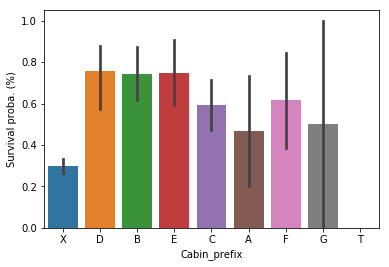

In [182]:
g = sns.barplot(y ='Target', x='Cabin_prefix',data=aux_X)
_ = g.set(xlabel='Cabin_prefix', ylabel='Survival proba. (%)')

Ticket special treatment: Same as Cabin

In [179]:
Ticket = []
for i in list(aux_X.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

aux_X["Ticket_prefix"] = Ticket

aux_X.drop("Ticket", axis=1, inplace=True)

aux_X["Ticket_prefix"].unique()

array(['X', 'AS', 'A5', 'FC', 'SOTONOQ', 'WC', 'STONO', 'LINE', 'C',
       'SOC', 'CA', 'STONO2', 'SOP', 'A4', 'PC', 'Fa', 'SCOW', 'PP',
       'SOTONO2', 'SOPP', 'SP', 'SCParis', 'SC', 'SWPP', 'SCPARIS', 'WEP',
       'PPP', 'SCAH', 'FCC', 'SCA4', 'CASOTON'], dtype=object)

/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


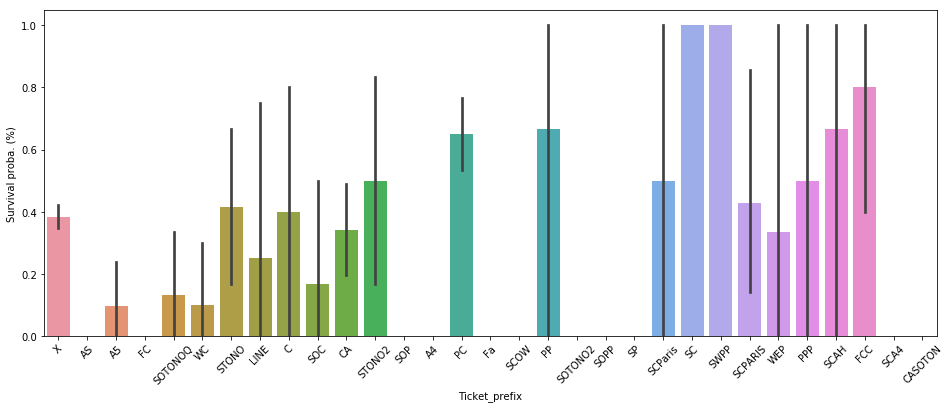

In [185]:
plt.figure(figsize=(16,6))
g = sns.barplot(y ='Target', x='Ticket_prefix',data=aux_X)
_ = g.set(xlabel='Ticket_prefix', ylabel='Survival proba. (%)')
_ = plt.xticks(rotation=45)

Name special treatment: Here we'll extract the title of each passenger

In [187]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in aux_X["Name"]]
aux_X["Title"] = pd.Series(dataset_title)

In [188]:
aux_X.drop("Name", axis=1, inplace=True)
aux_X["Title"].unique()

array(['Mr', 'Mrs', 'Master', 'Miss', 'Don', 'the Countess', 'Dr', 'Rev',
       'Sir', 'Mlle', 'Mme', 'Major', 'Lady', 'Jonkheer', 'Col', 'Capt',
       'Ms'], dtype=object)

In [189]:
aux_X["Title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Lady              1
Jonkheer          1
Sir               1
Don               1
the Countess      1
Ms                1
Capt              1
Mme               1
Name: Title, dtype: int64

In [190]:
# Convert to categorical values Title 
aux_X["Title"] = aux_X["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
aux_X["Title"] = aux_X["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
aux_X["Title"] = aux_X["Title"].astype(int)

In [191]:
aux_X["Title"].value_counts()

2    517
1    311
0     40
3     23
Name: Title, dtype: int64

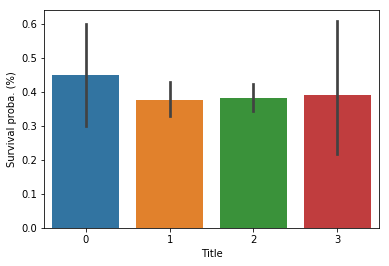

In [192]:
g = sns.barplot(y ='Target', x='Title',data=aux_X)
_ = g.set(xlabel='Title', ylabel='Survival proba. (%)')

Now we perform one engineering step: one-hot encoding of the categorical vars

In [193]:
cat_ft = ["Sex", "Embarked", "Title", "Ticket_prefix", "Cabin_prefix"]
cat_ft

['Sex', 'Embarked', 'Title', 'Ticket_prefix', 'Cabin_prefix']

In [194]:
aux_X_dum = pd.get_dummies(aux_X,columns=cat_ft, drop_first=True)

In [195]:
aux_train_imp_eng = aux_X_dum.iloc[X_train_idx]
aux_test_imp_eng = aux_X_dum.iloc[X_test_idx]

In [196]:
X_train_imp_eng = aux_train_imp_eng.drop("Target",axis=1)
y_train = aux_train_imp_eng.loc[:,"Target"]

X_test_imp_eng = aux_test_imp_eng.drop("Target",axis=1)
y_test = aux_test_imp_eng.loc[:,"Target"]

In [197]:
X_train_imp_eng.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_1,Title_2,...,Ticket_prefix_WEP,Ticket_prefix_X,Cabin_prefix_B,Cabin_prefix_C,Cabin_prefix_D,Cabin_prefix_E,Cabin_prefix_F,Cabin_prefix_G,Cabin_prefix_T,Cabin_prefix_X
705,2,39.0,0,0,26.0000,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
465,3,38.0,0,0,7.0500,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
571,1,53.0,2,0,51.4792,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
788,3,1.0,1,2,20.5750,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
729,3,25.0,1,0,7.9250,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [198]:
y_train.head()

705    0
465    0
571    1
788    1
729    0
Name: Target, dtype: int64

In [199]:
y_test.shape

(179,)

### 2.4 Feature Scaling

In [200]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler

In [201]:
sc = StandardScaler()
sc.fit(X_train_imp_eng)
X_train_imp_sc = sc.transform(X_train_imp_eng)
X_test_imp_sc = sc.transform(X_test_imp_eng)

/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


## 3. Modelling

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
import itertools

In [203]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [220]:
def create_basic_lr(X_train, y_train, X_test, y_test, model_name):
    basic_lr = LogisticRegression()
    basic_lr.fit(X_train, y_train)
    print('Accuracy: ',accuracy_score(y_test,basic_lr.predict(X_test)))
    print('F1-Score: ',f1_score(y_test,basic_lr.predict(X_test)))
    print('ROC AUC: ',roc_auc_score(y_test,basic_lr.predict(X_test)))
    cm = confusion_matrix(y_test,basic_lr.predict(X_test))
    plot_confusion_matrix(cm, ['Not Survived','Survived'],
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Oranges)
    return basic_lr

Accuracy:  0.8044692737430168
F1-Score:  0.6728971962616822
ROC AUC:  0.7566258193217441
Confusion matrix, without normalization
[[108  13]
 [ 22  36]]


/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


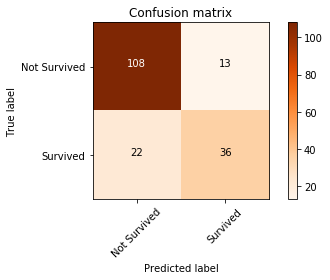

In [221]:
clf = create_basic_lr(X_train_imp_eng, y_train, X_test_imp_eng, y_test, 'clf1')

In [222]:
def plot_proba_dist_binary_clf(clf_bin, X_test, y_test):
    
    p_test_lr = clf_bin.predict_proba(X_test)[:,1]
    df_a = pd.DataFrame({"target":y_test, "pred_probas":p_test_lr})
    
    plt.figure(figsize=(12,6))
    _ = sns.distplot(df_p[df_p["target"]==1].loc[:,"pred_probas"],bins=20,kde=False,color="g")
    _ = sns.distplot(df_p[df_p["target"]==0].loc[:,"pred_probas"],bins=20,kde=False,color="b")

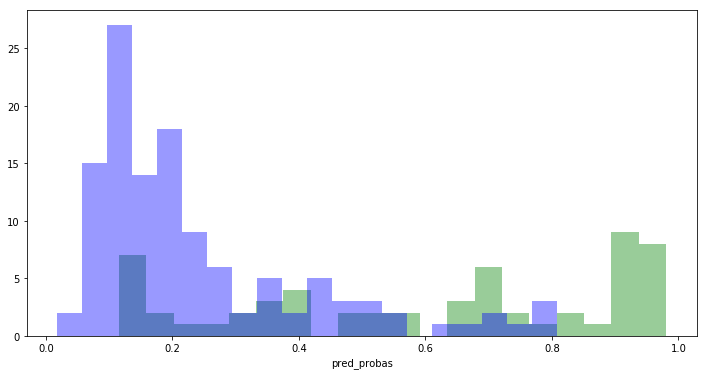

In [223]:
plot_proba_dist_binary_clf(clf, X_test_imp_eng, y_test)

In [208]:
from sklearn.ensemble import RandomForestClassifier

In [209]:
basic_rf = RandomForestClassifier()
basic_rf.fit(X_train_imp_eng, y_train)

/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy:  0.7932960893854749
F1-Score:  0.6942148760330579
Confusion matrix, without normalization
[[100  21]
 [ 16  42]]


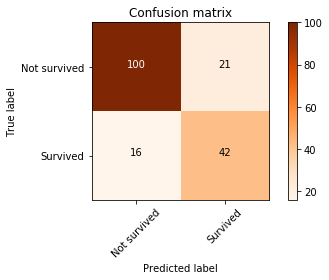

In [210]:
print('Accuracy: ',accuracy_score(y_test,basic_rf.predict(X_test_imp_eng)))
print('F1-Score: ',f1_score(y_test,basic_rf.predict(X_test_imp_eng)))
cm = confusion_matrix(y_test,basic_rf.predict(X_test_imp_eng))
plot_confusion_matrix(cm, ['Not survived','Survived'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges)

In [211]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10)

In [212]:
from sklearn.model_selection import GridSearchCV

# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 6, verbose = 1)

gsRFC.fit(X_train_imp_eng, y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   17.7s
[Parallel(n_jobs=6)]: Done 540 out of 540 | elapsed:   21.6s finished
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8132022471910112

Multiple Modelling Strategies

In [213]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [214]:
kfold = StratifiedKFold(n_splits=10)

In [224]:
random_state = 0
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_imp_eng, y = y_train, scoring = "f1", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

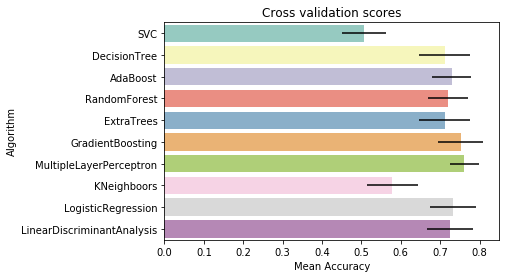

In [225]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean F1-Score")
g = g.set_title("Cross validation scores")

In [226]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train_imp_eng,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:    1.9s finished
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [227]:
gsadaDTC.best_score_

0.7415214710654079

In [228]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="f1", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train_imp_eng,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   18.1s finished
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7405737004363592

In [237]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10, 20],
              "min_samples_split": [2, 3, 10, 15],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,200,300,400],
              "criterion": ["gini","entropy"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train_imp_eng,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  3.1min finished
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7584603527273113

In [238]:
RFC_best

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=20,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [230]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train_imp_eng,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    9.7s finished
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7415551204835079

In [231]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="f1", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train_imp_eng,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    8.7s finished
/anaconda3/envs/ML_Alex_371/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7542455393705504

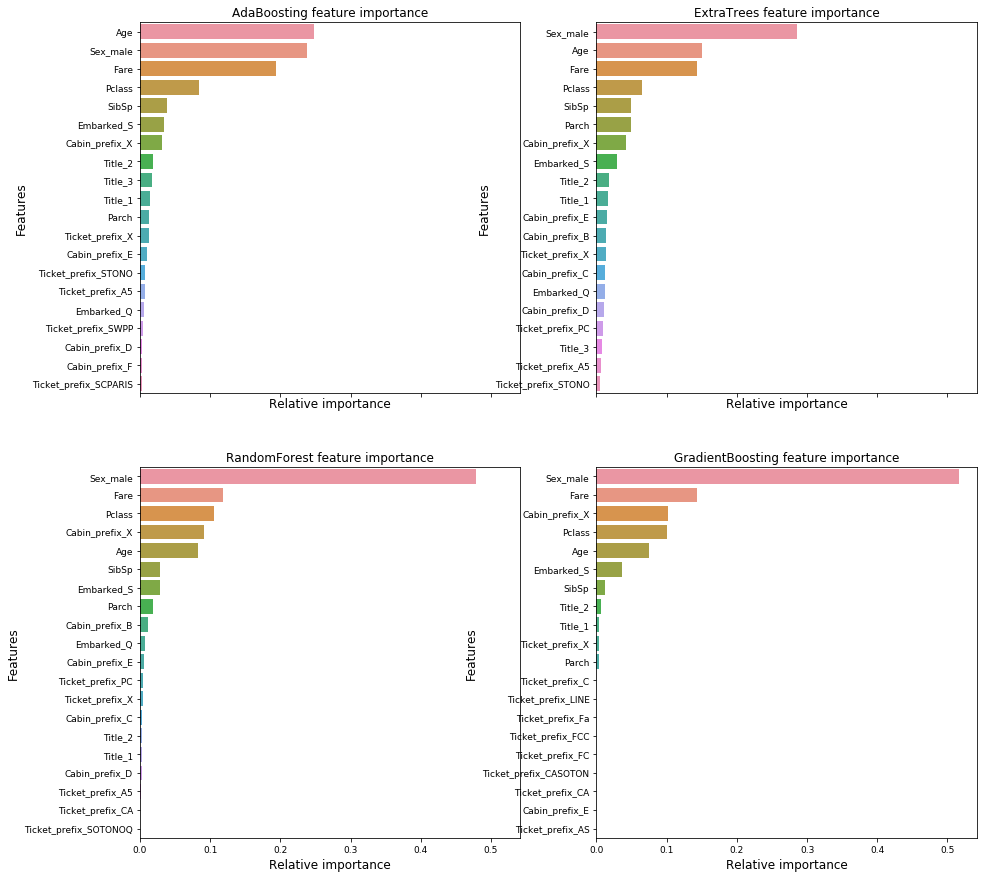

In [232]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X_train_imp_eng.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1



In [233]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train_imp_eng, y_train)

Accuracy:  0.8212290502793296
F1-Score:  0.7142857142857143
Confusion matrix, without normalization
[[107  14]
 [ 18  40]]


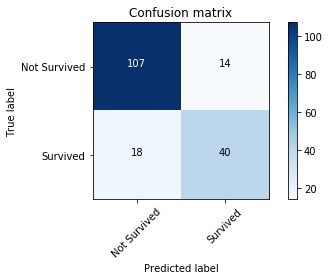

In [234]:
print('Accuracy: ',accuracy_score(y_test,votingC.predict(X_test_imp_eng)))
print('F1-Score: ',f1_score(y_test,votingC.predict(X_test_imp_eng)))
cm = confusion_matrix(y_test,votingC.predict(X_test_imp_eng))
plot_confusion_matrix(cm, ['Not Survived','Survived'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
